In [107]:
from eden_scripts.download_datasets import download, extract
import fsspec
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import pickle as pkl
import numpy as np


In [346]:
gt_similarities_queries_clip = pkl.load(open('./topK_similarities/gt_similarities_queries_clip.pkl', "rb"))
gt_similarities_queries_sae_5 = pkl.load(open('./topK_similarities/gt_similarities_queries_sae_5.pkl', "rb"))
gt_similarities_queries_sae_10 = pkl.load(open('./topK_similarities/gt_similarities_queries_sae_10.pkl', "rb"))
gt_similarities_queries_sae_20 = pkl.load(open('./topK_similarities/gt_similarities_queries_sae_20.pkl', "rb"))
gt_similarities_queries_sae = pkl.load(open('./topK_similarities/gt_similarities_queries_sae.pkl', "rb"))
nn_sae_5 = pkl.load(open('./topK_similarities/neighbours/nearest_neighbors_sae_top5.pkl', "rb"))
nn_sae_10 = pkl.load(open('./topK_similarities/neighbours/nearest_neighbors_sae_top_10.pkl', "rb"))
nn_sae_20 = pkl.load(open('./topK_similarities/neighbours/nearest_neighbors_sae_top_20.pkl', "rb"))
nn_sae = pkl.load(open('./results/nearest_neighbors.pkl', "rb"))
nn_clip = pkl.load(open('./topK_similarities/neighbours/nearest_neighbors_clip.pkl', "rb"))

In [ ]:
def find_image_in_folders(ref_folders, ref_id):
        ref_filename = f"R{ref_id:06d}.jpg"
        for folder in ref_folders:
            candidate = Path(folder) / ref_filename
            if candidate.exists():
                return candidate
        return None
    
def find_nearest_existing_neighbour(ref_folders, ref_id):
    """
    Finds the nearest existing neighbour image in the provided reference folders.
    ref_id: int, reference index to find.
    """
    ref_filename = f"R{ref_id:06d}.jpg"
    for folder in ref_folders:
        candidate = Path(folder) / ref_filename
        if candidate.exists():
            return candidate
    return None

def plot_similarities(query_folder, ref_folders, query_idx):
    """
    Plots similarities for a single query image.
    query_idx: int, query index to plot.
    """
    qidx = int(query_idx)
    fig, axs = plt.subplots(2, 6, figsize=(18, 6))

    assert qidx in KEYS_COMMON_GT, f"Query index {qidx} not found in common keys.\nAvailable keys: {KEYS_COMMON_GT}"
    
    axs = axs.flatten()

    axs[0].set_title('Query Image')
    query_image_path = Path(query_folder) / f"Q{qidx}.jpg"
    query_image = Image.open(query_image_path)
    axs[0].imshow(query_image)
    
    axs[6].set_title('Query Image')
    query_image_path = Path(query_folder) / f"Q{qidx}.jpg"
    query_image = Image.open(query_image_path)
    axs[6].imshow(query_image)

    axs[1].set_title(f'GT CLIP\nSimilarity={gt_similarities_queries_clip[qidx]["similarity"]:.2f}')
    clip_ref_id = gt_similarities_queries_clip[qidx]['gt_ref_idx']
    clip_image_path = find_image_in_folders(ref_folders, clip_ref_id)
    clip_image = Image.open(clip_image_path)
    axs[1].imshow(clip_image)

    axs[2].set_title(f'GT SAE\nSimilarity={gt_similarities_queries_sae[qidx]["similarity"]:.2f}')
    sae_ref_id = gt_similarities_queries_sae[qidx]['gt_ref_idx']
    sae_image_path = find_image_in_folders(ref_folders, sae_ref_id)
    sae_image = Image.open(sae_image_path)
    axs[2].imshow(sae_image)

    axs[3].set_title(f'GT SAE-Top5\nSimilarity={gt_similarities_queries_sae_5[qidx]["similarity"]:.2f}')
    sae5_ref_id = gt_similarities_queries_sae_5[qidx]['gt_ref_idx']
    sae5_image_path = find_image_in_folders(ref_folders, sae5_ref_id)
    sae5_image = Image.open(sae5_image_path)
    axs[3].imshow(sae5_image)

    axs[4].set_title(f'GT SAE-Top10\nSimilarity={gt_similarities_queries_sae_10[qidx]["similarity"]:.2f}')
    sae10_ref_id = gt_similarities_queries_sae_10[qidx]['gt_ref_idx']
    sae10_image_path = find_image_in_folders(ref_folders, sae10_ref_id)
    sae10_image = Image.open(sae10_image_path)
    axs[4].imshow(sae10_image)

    axs[5].set_title(f'GT SAE-Top20\nSimilarity={gt_similarities_queries_sae_20[qidx]["similarity"]:.2f}')
    sae20_ref_id = gt_similarities_queries_sae_20[qidx]['gt_ref_idx']
    sae20_image_path = find_image_in_folders(ref_folders, sae20_ref_id)
    sae20_image = Image.open(sae20_image_path)
    axs[5].imshow(sae20_image)
    
    axs[7].set_title('Nearest Neighbour (CLIP)')
    nn_clip_list = nn_clip[qidx]
    for i in range(len(nn_clip_list)):
        sim, ref_id, *_ = nn_clip_list[i]
        ref_img_path = None
        for folder in ref_folders:
            ref_filename = f"R{ref_id:06d}.jpg"
            candidate = Path(folder) / ref_filename
            if candidate.exists():
                ref_img_path = candidate
                break
    if ref_img_path is not None:
        axs[7].imshow(Image.open(ref_img_path))
        axs[7].set_title(f'Nearest Neighbour (CLIP)\nR{ref_id:06d}\nSimilarity={sim:.2f}')
    else:
        axs[7].text(0.5, 0.5, f'not found', ha='center', va='center')
        axs[7].set_title(f'Nearest Neighbour (CLIP)\nSimilarity={sim:.2f}\nImage not found')
    
    
    nn_sae_list = nn_sae[qidx]
    for i in range(len(nn_sae_list)):
        sim, ref_id, *_ = nn_sae_list[i]
        ref_img_path = None
        for folder in ref_folders:
            ref_filename = f"R{ref_id:06d}.jpg"
            candidate = Path(folder) / ref_filename
            if candidate.exists():
                ref_img_path = candidate
                break
    if ref_img_path is not None:
        axs[8].imshow(Image.open(ref_img_path))
        axs[8].set_title(f'Nearest Neighbour (SAE)\nR{ref_id:06d}\nSimilarity={sim:.2f}')
    else:
        axs[8].text(0.5, 0.5, f'not found', ha='center', va='center')
        axs[8].set_title(f'Nearest Neighbour (SAE)\nSimilarity={sim:.2f}\nImage not found')

    nn_sae_5_list = nn_sae_5[qidx]
    for i in range(len(nn_sae_5_list)):
        sim, ref_id, *_ = nn_sae_5_list[i]
        for folder in ref_folders:
            ref_filename = f"R{ref_id:06d}.jpg"
            candidate = Path(folder) / ref_filename
            if candidate.exists():
                ref_img_path = candidate
                break
    if ref_img_path is not None:
        axs[9].imshow(Image.open(ref_img_path))
        axs[9].set_title(f'Nearest Neighbour (SAE-Top5)\nR{ref_id:06d}\nSimilarity={sim:.2f}')
    else:
        axs[9].text(0.5, 0.5, f'not found', ha='center', va='center')
        axs[9].set_title(f'Nearest Neighbour (SAE-Top5)\nSimilarity={sim:.2f}\nImage not found')
        
    nn_sae_10_list = nn_sae_10[qidx]
    for i in range(len(nn_sae_10_list)):
        sim, ref_id, *_ = nn_sae_10_list[i]
        for folder in ref_folders:
            ref_filename = f"R{ref_id:06d}.jpg"
            candidate = Path(folder) / ref_filename
            if candidate.exists():
                ref_img_path = candidate
                break
    if ref_img_path is not None:
        axs[10].imshow(Image.open(ref_img_path))
        axs[10].set_title(f'Nearest Neighbour (SAE-Top10)\nR{ref_id:06d}\nSimilarity={sim:.2f}')
    else:
        axs[10].text(0.5, 0.5, f'not found', ha='center', va='center')
        axs[10].set_title(f'Nearest Neighbour (SAE-Top10)\nSimilarity={sim:.2f}\nImage not found')
        
    nn_sae_20_list = nn_sae_20[qidx]
    for i in range(len(nn_sae_20_list)):
        sim, ref_id, *_ = nn_sae_20_list[i]
        for folder in ref_folders:
            ref_filename = f"R{ref_id:06d}.jpg"
            candidate = Path(folder) / ref_filename
            if candidate.exists():
                ref_img_path = candidate
                break
    if ref_img_path is not None:
        axs[11].imshow(Image.open(ref_img_path))
        axs[11].set_title(f'Nearest Neighbour (SAE-Top20)\nR{ref_id:06d}\nSimilarity={sim:.2f}')
    else:
        axs[11].text(0.5, 0.5, f'not found', ha='center', va='center')
        axs[11].set_title(f'Nearest Neighbour (SAE-Top20)\nSimilarity={sim:.2f}\nImage not found')
        
    for i in range(12):
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()


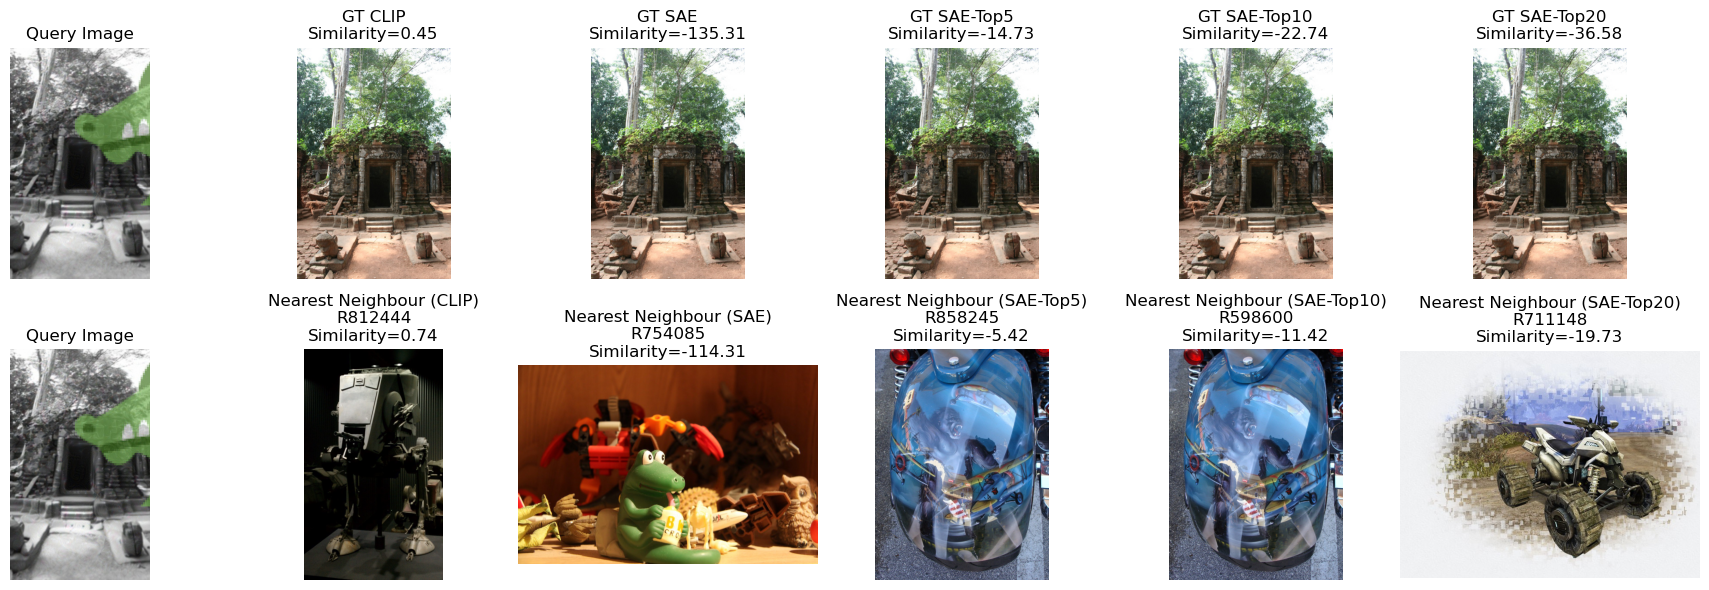

In [384]:
plot_similarities(query_folder="final_queries/images/final_queries",
    ref_folders=[
        "references/references0/images/references",
        "references/references10/images/references",
        "references/references12/images/references",
        "references/references13/images/references",
        "references/references14/images/references",
        "references/references15/images/references",
        "references/references16/images/references",
    ],
    query_idx=99835)

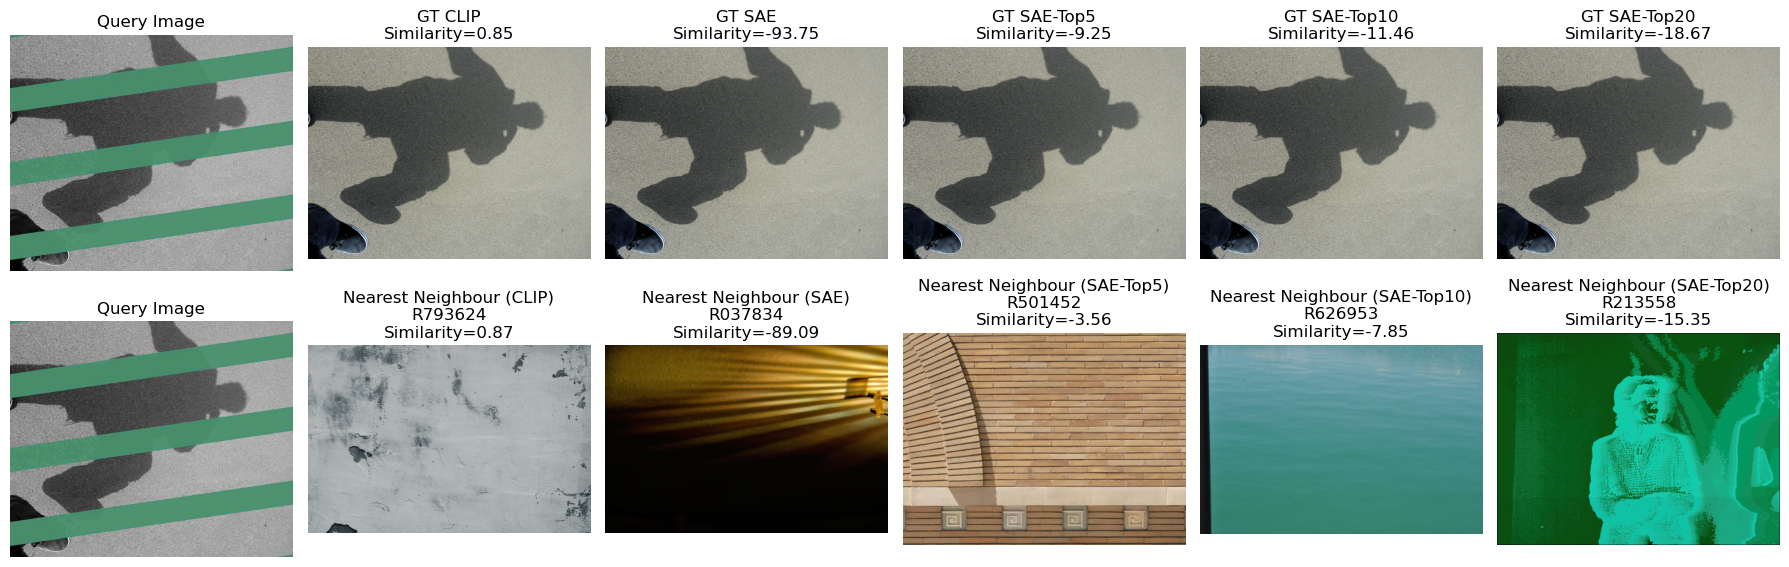

In [381]:
plot_similarities(query_folder="final_queries/images/final_queries",
    ref_folders=[
        "references/references0/images/references",
        "references/references10/images/references",
        "references/references12/images/references",
        "references/references13/images/references",
        "references/references14/images/references",
        "references/references15/images/references",
        "references/references16/images/references",
    ],
    query_idx=73589)

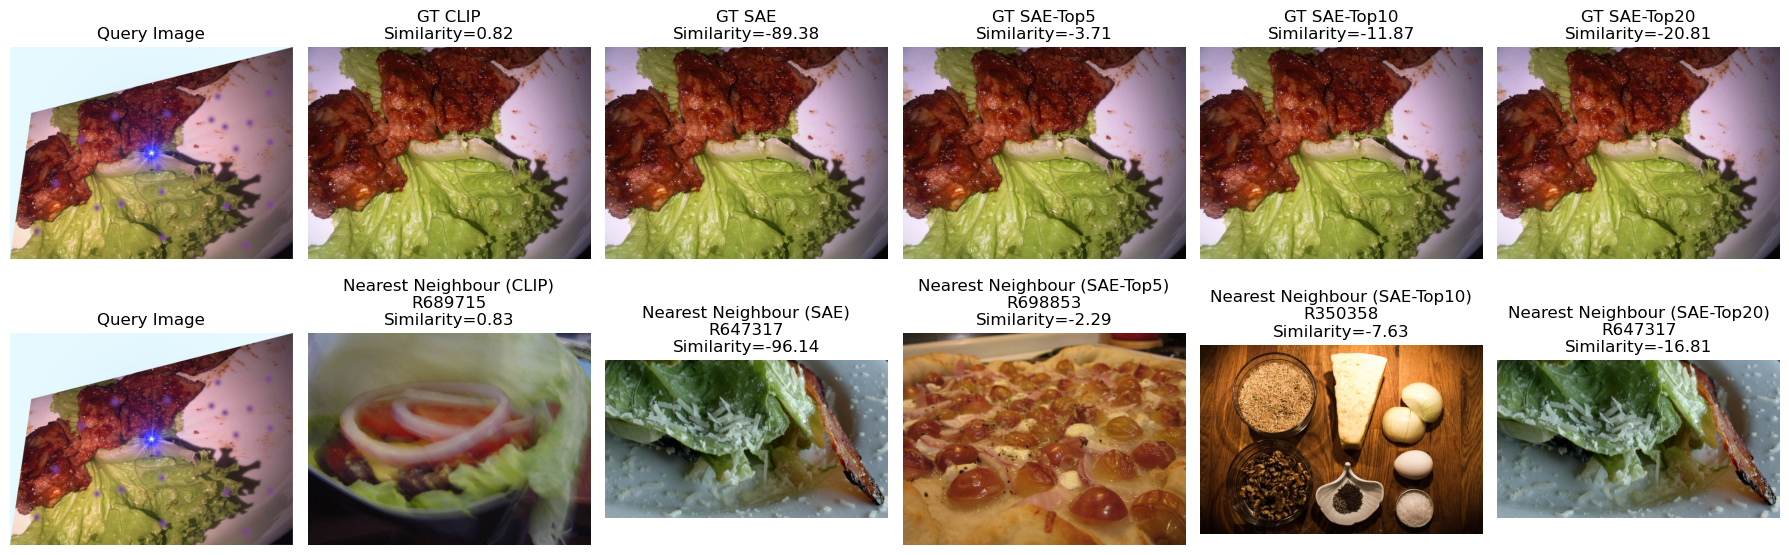

In [379]:
plot_similarities(query_folder="final_queries/images/final_queries",
    ref_folders=[
        "references/references0/images/references",
        "references/references10/images/references",
        "references/references12/images/references",
        "references/references13/images/references",
        "references/references14/images/references",
        "references/references15/images/references",
        "references/references16/images/references",
    ],
    query_idx=87668)

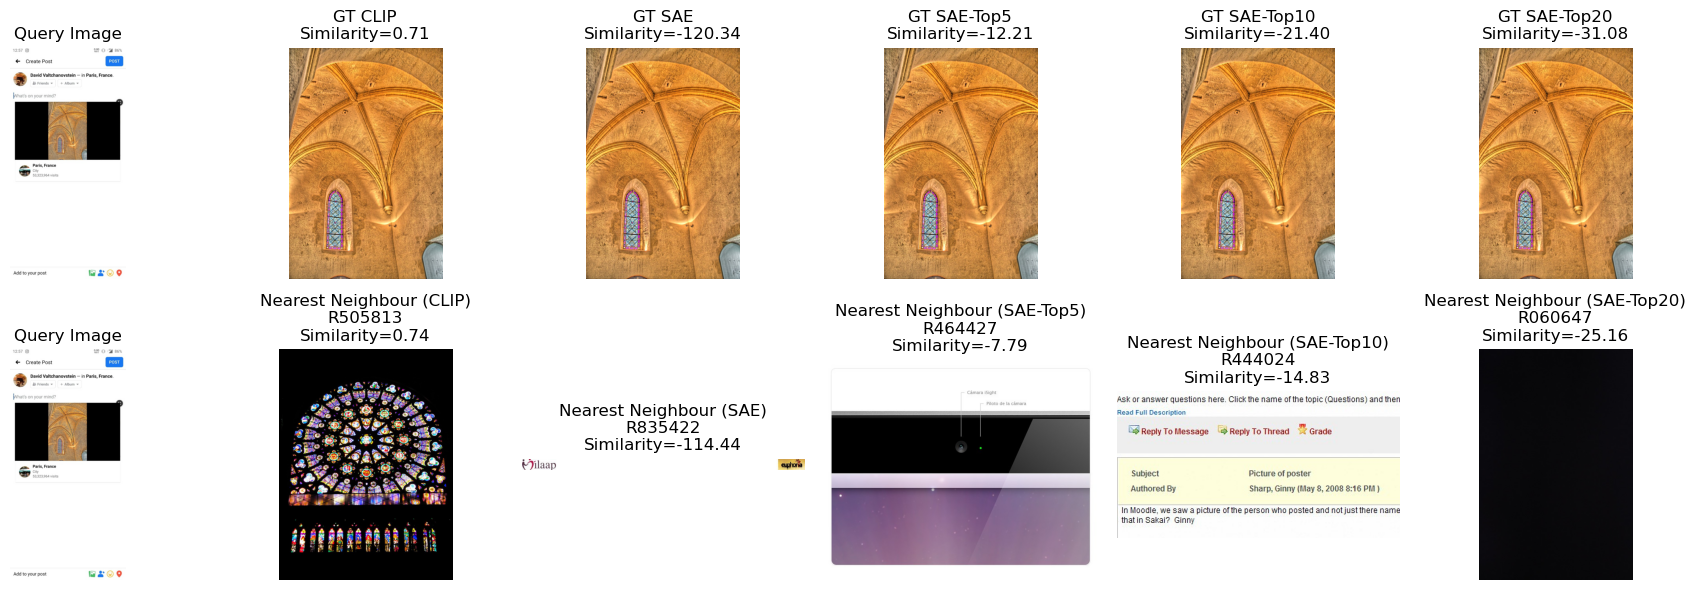

In [371]:
plot_similarities(query_folder="final_queries/images/final_queries",
    ref_folders=[
        "references/references0/images/references",
        "references/references10/images/references",
        "references/references12/images/references",
        "references/references13/images/references",
        "references/references14/images/references",
        "references/references15/images/references",
        "references/references16/images/references",
    ],
    query_idx=65753)

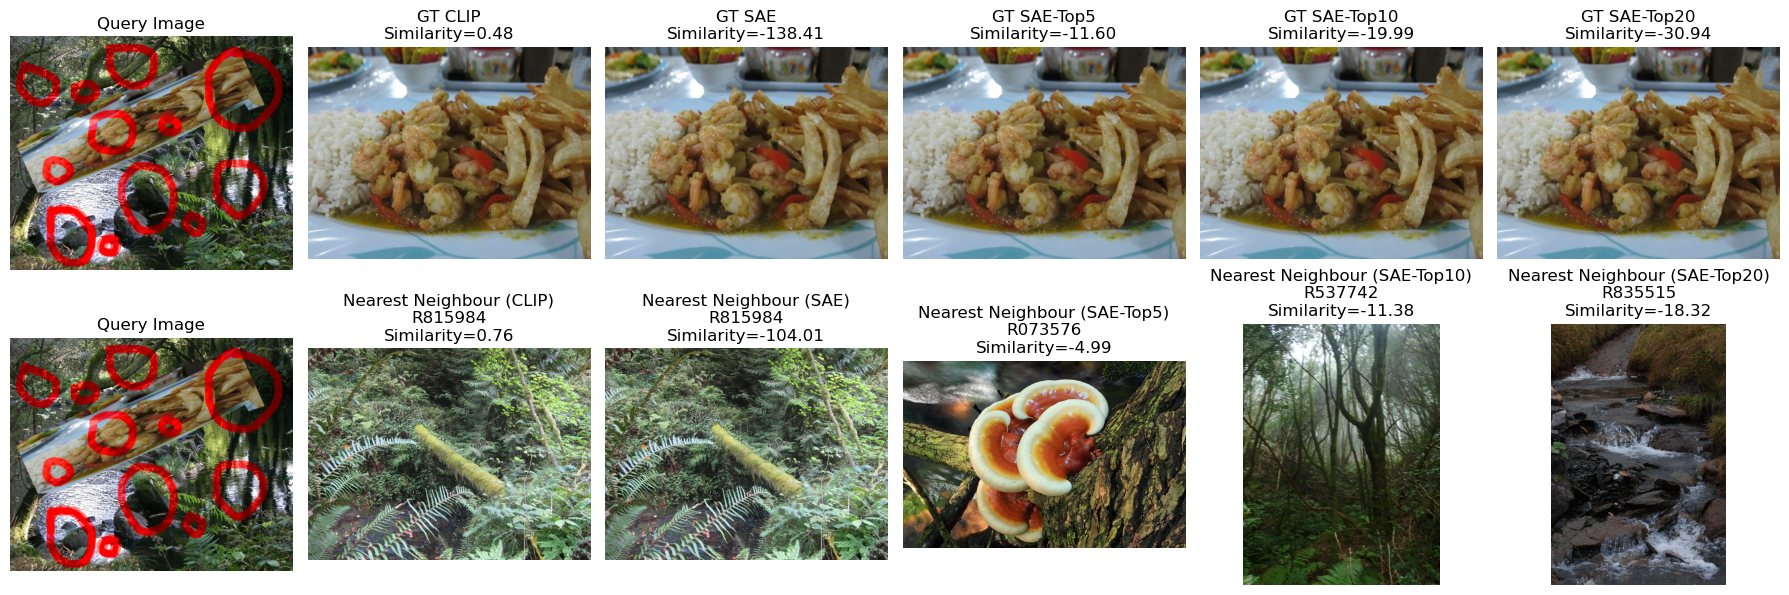

In [359]:
plot_similarities(query_folder="final_queries/images/final_queries",
    ref_folders=[
        "references/references0/images/references",
        "references/references10/images/references",
        "references/references12/images/references",
        "references/references13/images/references",
        "references/references14/images/references",
        "references/references15/images/references",
        "references/references16/images/references",
    ],
    query_idx=85413)

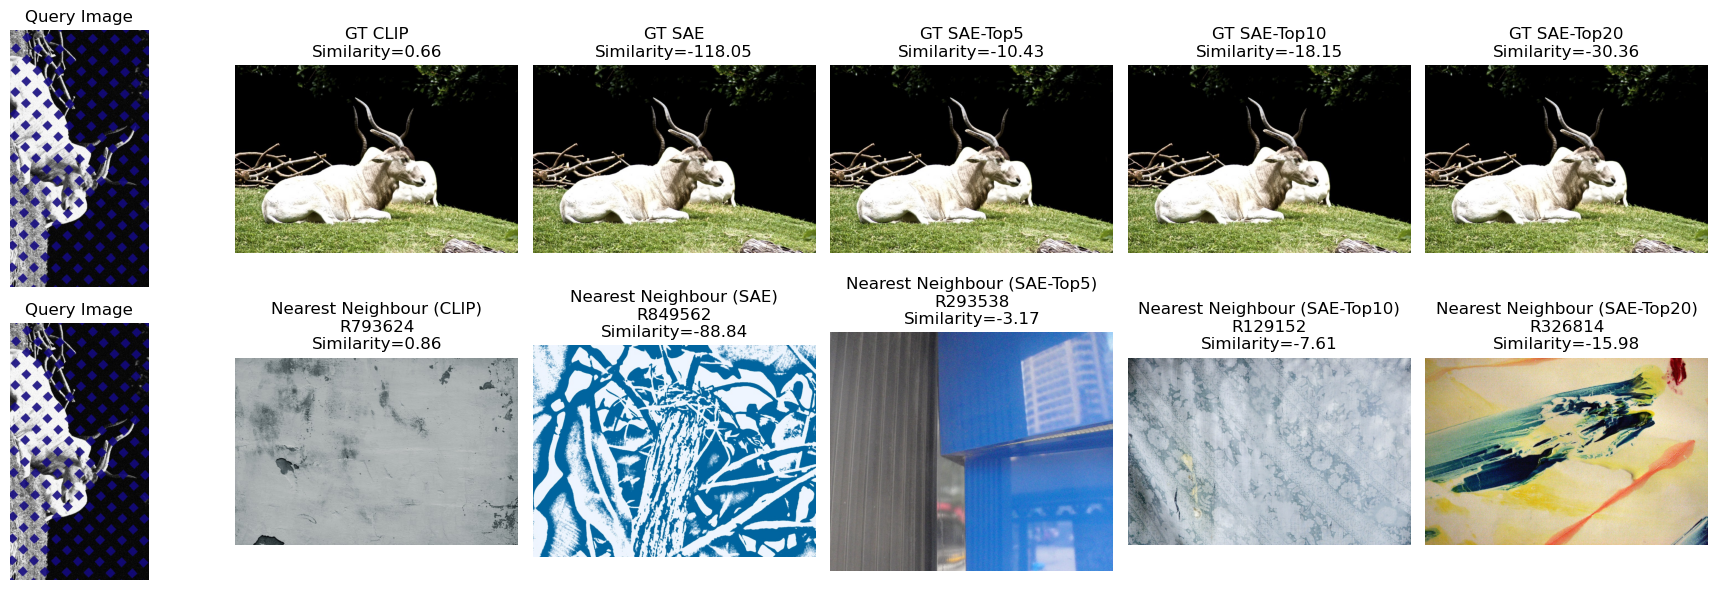

In [ ]:
plot_similarities(query_folder="final_queries/images/final_queries",
    ref_folders=[
        "references/references0/images/references",
        "references/references10/images/references",
        "references/references12/images/references",
        "references/references13/images/references",
        "references/references14/images/references",
        "references/references15/images/references",
        "references/references16/images/references",
    ],
    query_idx=67852)